## generate previous frames with pCO2 and fit it against ConvLSTM for different CESM members (Transfer Learning)

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

### Previous Frame generation

In [23]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    rmse1 = K.sqrt(K.mean(tf.math.squared_difference(y_pred1, y_true1),axis= -1))
    
    #y_pred2 = tf.boolean_mask(y_pred,idx2)
    #loss2 = 10*(K.var(y_true1)/K.var(y_pred2))
    #loss2 = tf.cast(loss2, y_pred.dtype)
    
    return rmse1


In [43]:
# Reading Data
dir = "../../data/"
dir_name = "../../data/member_001"
data_nums = ["034"]


# data_nums = ["001", "002", "009", "010", "011", "012", "013", "014", "015", "016", "017", "018", "020",
#              "021", "023", "024", "025", "030", "031", "034", "035", "101", "102", "103", "104"]

X_all = np.empty((0, 180, 360, 5))
y_all = np.empty((0, 180, 360))

for i in range(1):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num =data_nums[i])
    
    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    mld_images = preprocess_image_reduced(mld.MLD.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    y1 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
    #X1 = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X1 = X1.reshape((421,180,360,5),order='F')
    
    X_all = np.concatenate((X_all, X1))
    y_all = np.concatenate((y_all, y1))


In [44]:
INPUT_SHAPE=X_all[0].shape
OUTPUT_SHAPE=y_all[0].shape

INPUT_SHAPE, X_all.shape, y_all.shape

((180, 360, 5), (421, 180, 360, 5), (421, 180, 360))

In [45]:
cnn_model = tf.keras.models.load_model('../../models/base_model/u_net_dist.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image= cnn_model.predict(X_all,verbose=1)
predicted_image[y_all==0]=0.0

14/14 [==============================] - 22s 2s/step


In [46]:
print(custom_rmse(predicted_image,y_all))

tf.Tensor(2.9481953143660626, shape=(), dtype=float64)


In [47]:

y_true_all = np.empty((0,180,360))
y_pred_all = np.empty((0,180,360))


for i in range(1):
    tmp = i+1
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(dir_name,num =data_nums[i])
    y_true,y_pred = inverse_scale_image(predicted_image[421*(tmp-1):421*tmp],pco2t2.pCO2.data)
    y_true_all = np.concatenate((y_true_all, y_true))
    y_pred_all = np.concatenate((y_pred_all, y_pred))


print("y_shapes:", y_true_all.shape, y_pred_all.shape)
print("Full RMSE score:")
a=custom_rmse(y_pred_all,y_true_all)
print(a.numpy())


y_shapes: (421, 180, 360) (421, 180, 360)
Full RMSE score:
8.048832245940414


### Using the prediction as input in ConvLSTM

In [57]:
X_all_conv = np.empty((0, 3, 180, 360, 6))
y_all_conv = np.empty((0, 3, 180, 360, 1))
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3)

tmp = 1

for i in range(1):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num=data_nums[i])

    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    pco2 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    
    y = np.expand_dims(pco2[X_index][1:], axis=4)
    
    X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image[421*(tmp-1):421*tmp]))
    tmp+=1
    X = X.reshape((421,180,360,6),order='F')
    X = X[X_index][:-1]
    
    X_all_conv = np.concatenate((X_all_conv, X))
    y_all_conv = np.concatenate((y_all_conv, y))


shuffle_ind = (np.arange(X_all_conv.shape[0]))
np.random.shuffle(shuffle_ind)
X_all_conv = np.array(X_all_conv)[shuffle_ind.astype(int)]
y_all_conv = np.array(y_all_conv)[shuffle_ind.astype(int)]

X_all_conv.shape, y_all_conv.shape

((418, 3, 180, 360, 6), (418, 3, 180, 360, 1))

In [58]:
INPUT_SHAPE=X_all_conv[0].shape
OUTPUT_SHAPE=y_all_conv[0].shape

INPUT_SHAPE

(3, 180, 360, 6)

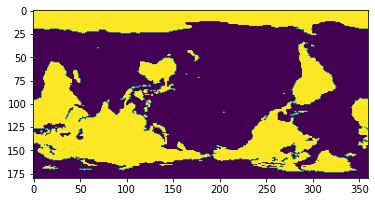

In [50]:
coord = (y_all_conv==0.0)
plt.imshow(coord[0][0])

In [51]:
# the masking continents for continent works better for pretrained model

In [80]:
model_path="../../models/ConvLSTM_with_pco2.h5"
convlstm_model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})

data,pco2 = preprocess_images_nfp(dir_name,"034")

X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 
X=data[X_index][:-1]

predicted_frames=convlstm_model.predict(X,verbose=1)
predicted_frames[coord] = 0

chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(dir_name,"034")

tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)
y_true_full.shape

14/14 [==============================] - 250s 18s/step


(418, 3, 180, 360, 1)

In [81]:
a=custom_rmse(predicted_frames,y_true_full)
print(a)

tf.Tensor(261.45457842638837, shape=(), dtype=float64)


### Transfer Learning

In [82]:
for layer in convlstm_model.layers[:-2]:
    layer.trainable = False

convlstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8

In [83]:
convlstm_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

model_path="../../models/transfer_CNN_LSTM.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
epochs = 5
batch_size = 16

In [84]:
history = convlstm_model.fit(
    X_all_conv,
    y_all_conv,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_all_conv, y_all_conv),
    callbacks=callbacks,
)

Epoch 1/5
27/27 [==============================] - 680s 25s/step - loss: 3.4922 - val_loss: 3.3923
Epoch 2/5
27/27 [==============================] - 670s 25s/step - loss: 3.3612 - val_loss: 3.3936
Epoch 3/5
27/27 [==============================] - 668s 25s/step - loss: 3.3495 - val_loss: 3.3512
Epoch 4/5
27/27 [==============================] - 678s 25s/step - loss: 3.3467 - val_loss: 3.3291
Epoch 5/5
27/27 [==============================] - 667s 25s/step - loss: 3.3364 - val_loss: 3.3254


In [92]:
tf_model = tf.keras.models.load_model("../../models/transfer_CNN_LSTM.h5", custom_objects={'custom_rmse':custom_rmse})

data,pco2 = preprocess_images_nfp(dir_name,"034")

X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 
X=data[X_index][:-1]

predicted_frames=tf_model.predict(X,verbose=1)
predicted_frames[coord] = 0

chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(dir_name,"034")

tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][:-1])
y_true_full = np.expand_dims(tmp,axis=4)
y_true_full.shape

14/14 [==============================] - 250s 18s/step


(418, 3, 180, 360, 1)

In [93]:
print("Full RMSE score:")
a=custom_rmse(predicted_frames, y_true_full)
print(a)

Full RMSE score:
tf.Tensor(261.30247305332017, shape=(), dtype=float64)


In [88]:
# gif generation for conv-lstm
import matplotlib.colors as mcolors
import imageio

norm = mcolors.Normalize(vmin=0, vmax = 750)
norm2 = mcolors.TwoSlopeNorm(vmin=-500, vmax = 500, vcenter=0)


filenames = []

for i in range(418):
    figure, axis = plt.subplots(1, 3,figsize=(18, 10))
    
    img=axis[0].imshow(np.flipud(predicted_frames[i,1:2][0]),cmap="coolwarm", interpolation="nearest", norm=norm)
    axis[0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[1].imshow(np.flipud(y_true_full[i,1:2][0]),cmap="coolwarm", interpolation="nearest",norm=norm)
    axis[1].set_title("true")

    img2=axis[2].imshow(np.flipud(y_true_full[i,1:2][0]-(predicted_frames[i,1:2][0])),cmap="RdBu", norm=norm2)
    axis[2].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    text = "rmse: "+str(np.round(np.sqrt(np.mean((y_true_full[i,1:2][0]-predicted_frames[i,1:2][0])**2)),2))
    plt.text(-60, -60, text, fontsize = 20)
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../../assets/convlstm_cesm_2.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)



In [89]:
def inverse_scale_frame_socat(arr,df, X_index=[]):
    """
    inverse_scale_frame(arr, df):
    - inverses the pco2 scaling
    """
    old_min = 0
    df_tmp = df[df!=0.0]
    old_max = np.nanmax(df_tmp)
    y_pred = arr*(old_max-old_min)/255+old_min
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

